In [8]:
#import libaries
import keras
import keras.utils as image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from glob import glob
from sklearn.decomposition import PCA
from scipy.spatial import distance
#set model to previously-trained neural network, that of VGG16
model = keras.applications.VGG16(weights='imagenet', include_top=True)
#only need to last layer
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In [2]:
cat_files = glob('../test_set/cats/*.jpg')
dog_files = glob('../test_set/dogs/*.jpg')

images = cat_files

In [3]:
with open('test.npy', 'rb') as f:
    a = np.load(f)

features = np.array(a)
pca = PCA(n_components=300)
pca.fit(features)

pca_features = pca.transform(features)

In [6]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [19]:
def get_new_image(i):
    # load image and extract features
    new_image, x = load_image(i)
    new_features = feat_extractor.predict(x)

    # project it into pca space
    new_pca_features = pca.transform(new_features)[0]

    # calculate its distance to all the other images pca feature vectors
    distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
    results_image = get_concatenated_images(idx_closest, 200)
    return new_image,results_image




In [ ]:
new_image,results_image = get_new_image(dog_files[10])
# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [20]:
def fix_image(upload):
    #i = Image.open(upload)
    new_image, results_image = get_new_image(upload)
    # display the results
    plt.figure(figsize = (5,5))
    plt.imshow(new_image)
    plt.title("query image")

    # display the resulting images
    plt.figure(figsize = (16,12))
    plt.imshow(results_image)
    plt.title("result images")



1/1 [==============================] - 0s 239ms/step


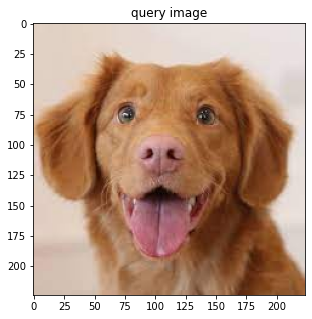

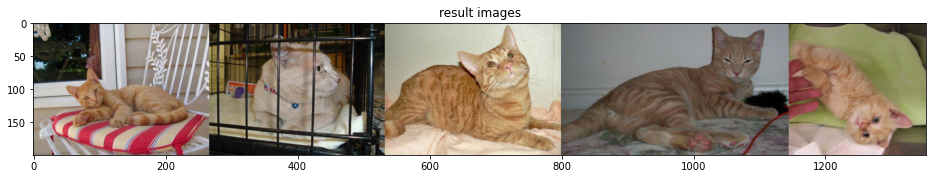

In [22]:
my_upload = "./dog_input.jpg"
if my_upload is not None:
    fix_image(upload=my_upload)
else:
    fix_image("./dog_input.jpg")